In [ ]:
# nbdev: hide this cell and export functions to `model_analysis` by default
# hide
# default_exp model_fitting

# Likelihood-Based Model Fitting

We'll demo a way to fit models to datasets with item repetitions based on the likelihood of each recall event given the model and a specified parameter configuration. The big difference from more traditional datasets is the variable item presentation orders across trials. This requires extra model simulation, since study phases can't be simulated just once. To ensure code is performant, we use a few tricks to keep simulations to a minimum.

In [ ]:
# export

import numpy as np
from numba import njit
from repfr.models import DefaultCMR

@njit(fastmath=True, nogil=True)
def cmr_rep_likelihood(
        trials, presentations, list_types, list_length, encoding_drift_rate, start_drift_rate, 
        recall_drift_rate, shared_support, item_support, learning_rate, 
        primacy_scale, primacy_decay, stop_probability_scale, 
        stop_probability_growth, choice_sensitivity):
    """
    Generalized cost function for fitting the InstanceCMR model optimized 
    using the numba library.
    
    Output scales inversely with the likelihood that the model and specified 
    parameters would generate the specified trials. For model fitting, is 
    usually wrapped in another function that fixes and frees parameters for 
    optimization.

    **Arguments**:
    - data_to_fit: typed list of int64-arrays where rows identify a unique 
        trial of responses and columns corresponds to a unique recall index.  
    - A configuration for each parameter of `InstanceCMR` as delineated in 
        `Formal Specification`.

    **Returns** the negative sum of log-likelihoods across specified trials 
    conditional on the specified parameters and the mechanisms of InstanceCMR.
    """

    likelihood = np.ones((len(trials), list_length))
    
    # we can use the same model for list types 1 and 2
    stable_models = [DefaultCMR(
            list_length, list_length, encoding_drift_rate, start_drift_rate, 
            recall_drift_rate, shared_support, item_support, learning_rate, 
            primacy_scale, primacy_decay, stop_probability_scale, 
            stop_probability_growth, choice_sensitivity), 
                    DefaultCMR(
            int(list_length/2), list_length, encoding_drift_rate, start_drift_rate, 
            recall_drift_rate, shared_support, item_support, learning_rate, 
            primacy_scale, primacy_decay, stop_probability_scale, 
            stop_probability_growth, choice_sensitivity)]
    stable_models[0].experience(np.eye(list_length, list_length))
    stable_models[1].experience(np.eye(int(list_length/2), int(list_length/2))[np.repeat(np.arange(int(list_length/2)), 2)])

    for trial_index in range(len(trials)):

        item_count = np.max(presentations[trial_index])+1
        
        if list_types[trial_index] > 2:
            model = DefaultCMR(
                item_count, list_length, encoding_drift_rate, start_drift_rate, 
                recall_drift_rate, shared_support, item_support, learning_rate, 
                primacy_scale, primacy_decay, stop_probability_scale, 
                stop_probability_growth, choice_sensitivity)

            model.experience(np.eye(item_count, item_count)[presentations[trial_index]])
        else:
            model = stable_models[list_types[trial_index]-1]
            
        trial = trials[trial_index]

        model.force_recall()
        for recall_index in range(len(trial) + 1):

            # identify index of item recalled; if zero then recall is over
            if recall_index == len(trial) and len(trial) < item_count:
                recall = 0
            elif trial[recall_index] == 0:
                recall = 0
            else:
                recall = presentations[trial_index][trial[recall_index]-1] + 1

            # store probability of and simulate recalling item with this index
            likelihood[trial_index, recall_index] = \
                model.outcome_probabilities(model.context)[recall]

            if recall == 0:
                break
            model.force_recall(recall)

        # reset model to its pre-retrieval (but post-encoding) state
        model.force_recall(0)

    return -np.sum(np.log(likelihood))

For model fitting, we have to prepare a wrapper function that calls `cmr_rep_likelihood` using static parameters for some values:

In [ ]:
# export

def cmr_rep_objective_function(data_to_fit, presentations, list_types, list_length, fixed_parameters, free_parameters):
    """
    Generates and returns an objective function for input to support search 
    through parameter space for ICMR model fit using an optimization function.

    Arguments:  
    - fixed_parameters: dictionary mapping parameter names to values they'll 
        be fixed to during search, overloaded by free_parameters if overlap  
    - free_parameters: list of strings naming parameters for fit during search  
    - data_to_fit: array where rows identify a unique trial of responses and 
        columns corresponds to a unique recall index

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of icmr_likelihood using the model 
    class, all parameters, and provided data.
    """
    return lambda x: cmr_rep_likelihood(data_to_fit, presentations, list_types, list_length, **{**fixed_parameters, **{
        free_parameters[i]:x[i] for i in range(len(x))}})

## Single-Subject Demo

In [ ]:
from repfr.datasets import prepare_repdata

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_repdata(
    'data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


In [ ]:
import numpy as np

lb = np.finfo(float).eps
hand_fit_parameters = {
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

cmr_rep_likelihood(trials[:48], presentations[:48], list_types[:48], list_length, **hand_fit_parameters)

3503.5476223695455

In [ ]:
%%timeit
cmr_rep_likelihood(trials[:48], presentations[:48], list_types[:48], list_length, **hand_fit_parameters)

Now we perform the single-subject fitting...

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = cmr_rep_objective_function(
    trials[:48], presentations[:48], list_types[:48], list_length, {}, free_parameters)

result = differential_evolution(cost_function, bounds, disp=True)
print(result)

```
     fun: 1867.69002758535
     jac: array([-0.67825567, -0.0390628 ,  1.13855094, -0.69376256, -0.76609013,
        0.09645191,  0.21655069, -0.12521468,  2.94776328, -0.05979928,
       -0.26766429])
 message: 'Optimization terminated successfully.'
    nfev: 16944
     nit: 75
 success: True
       x: array([8.23734393e-01, 6.87377340e-01, 9.63817756e-01, 7.92149143e-02,
       2.95856638e-01, 2.50030299e-01, 5.94400358e+00, 1.61904883e-01,
       1.54430590e-03, 2.56455105e-01, 1.61047189e+00])
```

In [ ]:
from repfr.model_analysis import sim_recall_probability_by_lag

stored_result = [8.23734393e-01, 6.87377340e-01, 9.63817756e-01, 7.92149143e-02,
       2.95856638e-01, 2.50030299e-01, 5.94400358e+00, 1.61904883e-01,
       1.54430590e-03, 2.56455105e-01, 1.61047189e+00]

parameters = {
    'presentation_count': list_length, 
}

cmr_result = sim_recall_probability_by_lag(
    DefaultCMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    presentations[list_types==4],  experiment_count=100)

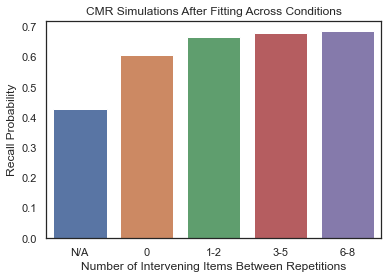

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

tips = sns.load_dataset("tips")
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=cmr_result[-1])
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('CMR Simulations After Fitting Across Conditions')
plt.show()